In [50]:
import os
from progressbar import ProgressBar
import numpy as np
import pandas as pd
import spectres
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.visualization import time_support
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 6
plt.rcParams['font.size'] = '18'

In [2]:
### Establish Directories and files
input_dir   = '/home/trevor/OneDrive/Coding/Pandora/Schedule_Optimizer/Pandora_schedule_optimizer/'
target_file = 'Pandora_target_list.csv'
gmat_file   = 'GMAT_Pandora.txt'
output_dir  = '/home/trevor/OneDrive/Coding/Pandora/Schedule_Optimizer/Results/'

### Establish observation parameters
Sun_constraint  = 90. *u.deg
Moon_constraint  = 40. *u.deg
Earth_constraint = 63. *u.deg
obs_start = '2025-04-25 00:00:00.000'
obs_stop  = '2026-04-25 00:00:00.000'

### Create an array for Pandora observation year in MJD_UTC with exactly 1 min spacing

In [3]:
# datetime 
Dt_iso_utc = pd.date_range(obs_start, obs_stop, freq='min')
Dt_iso_utc = Dt_iso_utc.to_pydatetime()
Dt_iso_utc = Time(Dt_iso_utc, format='datetime', scale='utc')
dt_iso_utc = Dt_iso_utc.to_value('datetime')

# iso 
t_iso_utc  = Dt_iso_utc.to_value('iso')
T_iso_utc  = Time(t_iso_utc, format='iso', scale='utc')

# mjd 
t_mjd_utc = T_iso_utc.to_value('mjd')
T_mjd_utc = Time(t_mjd_utc, format='mjd', scale='utc')

### Read in GMAT file

In [4]:
GMAT_file = '/home/trevor/OneDrive/Coding/Pandora/Schedule_Optimizer/Pandora_schedule_optimizer/GMAT_Pandora.txt'

df = pd.read_csv(GMAT_file, sep='\t')

# Trim dataframe to slightly larger than date range of 
# Pandora science lifetime defined as obs_start and obs_stop
df = df[(df['Earth.UTCModJulian']>=(T_mjd_utc.jd[0]-2430000.0)-1) & 
        (df['Earth.UTCModJulian']<=(T_mjd_utc.jd[-1]-2430000.0)+1)]
# df

### Convert GMAT times into standard MJD_UTC
#Note: GMAT uses different offset for it's MJD (uses 2,430,000.0 rather than 2,400,000.5)

### Extract GMAT positions in MJ2000 Earth fixed cartesian coordinates

In [5]:
# Earth
GMAT_ex = np.array(df['Earth.EarthMJ2000Eq.X'])
GMAT_ey = np.array(df['Earth.EarthMJ2000Eq.Y'])
GMAT_ez = np.array(df['Earth.EarthMJ2000Eq.Z'])

# Pandora
GMAT_px = np.array(df['Pandora.EarthMJ2000Eq.X'])
GMAT_py = np.array(df['Pandora.EarthMJ2000Eq.Y'])
GMAT_pz = np.array(df['Pandora.EarthMJ2000Eq.Z'])

# Sun
GMAT_sx = np.array(df['Sun.EarthMJ2000Eq.X'])
GMAT_sy = np.array(df['Sun.EarthMJ2000Eq.Y'])
GMAT_sz = np.array(df['Sun.EarthMJ2000Eq.Z'])

# Moon
GMAT_mx = np.array(df['Luna.EarthMJ2000Eq.X'])
GMAT_my = np.array(df['Luna.EarthMJ2000Eq.Y'])
GMAT_mz = np.array(df['Luna.EarthMJ2000Eq.Z'])

#### Look at time step sizes from GMAT

In [6]:
t_diff = np.zeros(len(gmat_mjd_utc)-1)
for i in range(len(gmat_mjd_utc)-1):
    t_diff[i] = (gmat_mjd_utc[i+1]-gmat_mjd_utc[i])

print('Min GMAT time step: ', min(t_diff*24*60), ' minutes')
print('Max GMAT time step: ', max(t_diff*24*60), ' minutes')

Min GMAT time step:  0.28820402920246124  minutes
Max GMAT time step:  1.000000610947609  minutes


### Interpolate all positions from GMAT to map to 1 minute intervals

In [7]:
#Earth
ex = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_ex)
ey = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_ey)
ez = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_ez)

#Pandora
px = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_px)
py = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_py)
pz = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_pz)

#Moon
mx = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_mx)
my = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_my)
mz = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_mz)

#Sun
sx = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_sx)
sy = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_sy)
sz = np.interp(t_mjd_utc, gmat_mjd_utc, GMAT_sz)

## Coordinate shift to Pandora reference frame

In [11]:
#Earth
exx = ex-px
eyy = ey-py
ezz = ez-pz

#Pandora
pxx = px-px
pyy = py-py
pzz = pz-pz

#Sun
sxx = sx-px
syy = sy-py
szz = sz-pz

#Moon
mxx = mx-px
myy = my-py
mzz = mz-pz

### Create SkyCoord for angular seperation calculations

In [12]:
ss = SkyCoord(x=sxx, y=syy, z=szz, unit='km', representation_type='cartesian')
ee = SkyCoord(x=exx, y=eyy, z=ezz, unit='km', representation_type='cartesian')
mm = SkyCoord(x=mxx, y=myy, z=mzz, unit='km', representation_type='cartesian')
pp = SkyCoord(x=pxx, y=pyy, z=pzz, unit='km', representation_type='cartesian')

### Establish angle constraints for Earth, Moon, Sun

In [13]:
# Sun_constraint = 90 *u.deg
# Moon_constraint = 40 *u.deg
# Earth_constraint = 63. *u.deg #based on worst case orbital alt of 450km 



## Test case for GJ 3470b

In [16]:
planet_name = 'GJ 3470 b'
planet = SkyCoord.from_name(planet_name) 

print('Calculating angular seperation requirements')
Sun_req = np.zeros(len(pp))
Moon_req = np.zeros(len(pp))
Earth_req = np.zeros(len(pp))

pbar = ProgressBar()
for i in pbar(range(len(pp))):
    Sun_req[i]   = ss[i].separation(planet).deg * u.deg > Sun_constraint
    Moon_req[i]  = mm[i].separation(planet).deg * u.deg > Moon_constraint
    Earth_req[i] = ee[i].separation(planet).deg * u.deg > Earth_constraint
all_req = Sun_req*Moon_req*Earth_req

Calculating angular seperation requirements


100% |########################################################################|


In [26]:
ss

<SkyCoord (ICRS): (x, y, z) in km
    [(1.23724188e+08, 78592043.86461863, 34067368.52821244),
     (1.23723210e+08, 78593459.05943887, 34067504.21972311),
     (1.23722262e+08, 78594870.73480326, 34067641.1058194 ), ...,
     (1.24085951e+08, 78090402.37039801, 33843972.09649307),
     (1.24085375e+08, 78091822.59588833, 33844359.79456582),
     (1.24084811e+08, 78093240.21196233, 33844775.02195489)]>

In [27]:
ss.transform_to('fk5')

<SkyCoord (FK5: equinox=J2000.000): (ra, dec, distance) in (deg, deg, km)
    [(32.42452563, 13.08448913, 1.50482456e+08),
     (32.42519751, 13.08454518, 1.50482422e+08),
     (32.42586197, 13.08459967, 1.50482411e+08), ...,
     (32.18324468, 12.99838333, 1.50468763e+08),
     (32.18383438, 12.99850416, 1.50469112e+08),
     (32.18442054, 12.99863439, 1.50469477e+08)]>

### Save results

In [17]:
### Set up directory
output_dir = '/home/trevor/OneDrive/Coding/Pandora/Schedule_Optimizer/Results/'
save_dir = output_dir + planet_name + '/'
if os.path.exists(save_dir) != True:
    os.makedirs(save_dir)

Saving results to:  /home/trevor/OneDrive/Coding/Pandora/Schedule_Optimizer/Results/GJ 3470 b/


In [37]:
### Create data array for saving and save results as csv    
data = np.vstack((np.array(list(t_mjd_utc[:])), Earth_req, Moon_req, Sun_req, all_req))
data = data.T.reshape(-1,5)

print('Saving results to ', save_dir)
np.savetxt((output_dir+planet_name+'/'+'sep_angles.csv'), data, 
           delimiter=',', header='Time(MJD_UTC),Earth_Clear,Moon_Clear,Sun_Clear,Visible', comments='')

## Plotting results

In [17]:
# Space out the individual requirements
Sun_r = Sun_req * 0.25
Moon_r = Moon_req * 0.50
Earth_r = Earth_req * 0.75

### Plot entire observing year

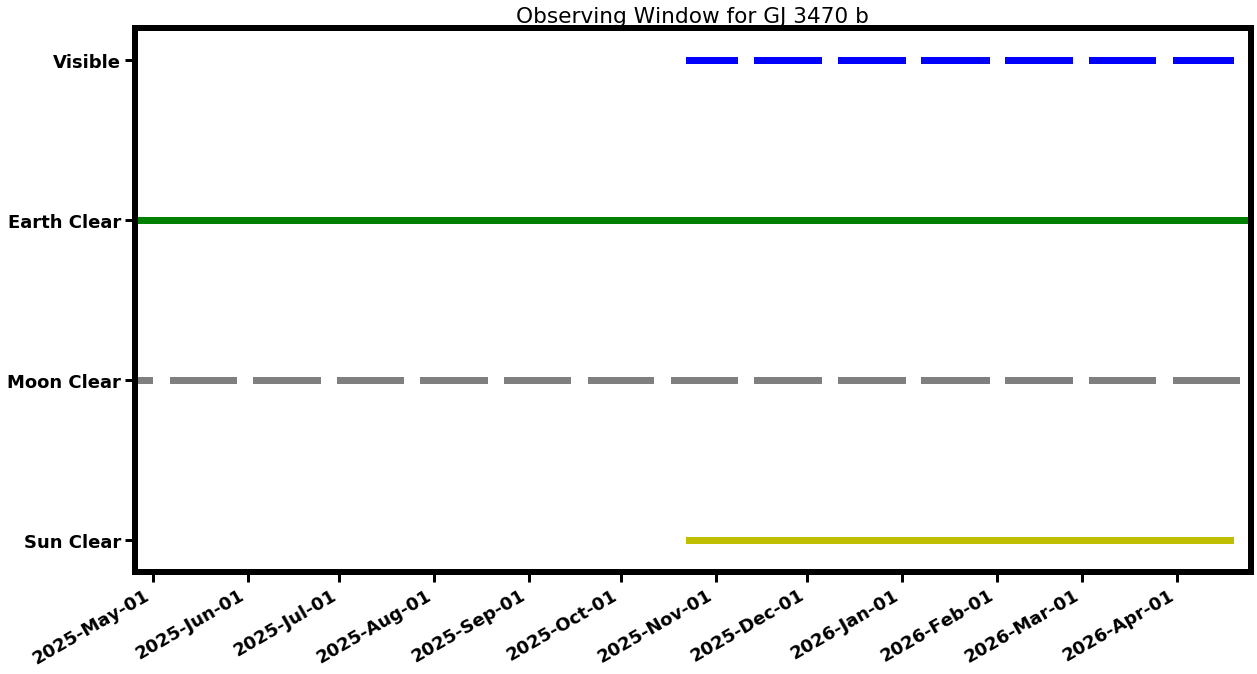

In [18]:
fig, axs = plt.subplots(1,1, figsize=(20,10))
axs.plot(dt_iso_utc, Sun_r  , 'y|')
axs.plot(dt_iso_utc, Moon_r , 'C7|')
axs.plot(dt_iso_utc, Earth_r, 'g|')
axs.plot(dt_iso_utc, all_req, 'b|')

axs.set_title('Observing Window for %s' %planet_name)
axs.xaxis.set_major_locator(mpl.dates.MonthLocator())
axs.xaxis.set_minor_locator(mpl.dates.DayLocator())
axs.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d'))
axs.set_yticks([0,0.25, 0.5, 0.75, 1])
axs.set_yticklabels(['Blocked', 'Sun Clear', 'Moon Clear', 'Earth Clear', 'Visible'])
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs.set_ylim(0.2, 1.05)
axs.set_xlim(dt_iso_utc[0], dt_iso_utc[-1])

# Save observing year plot
# plt.savefig(save_dir+'Observing Calendar for '
#             +planet_name+'.png')
plt.show()

### Plot a zoomed in portion

In [48]:
start = datetime(2025, 10, 24, 12, 0)
stop  = datetime(2025, 10, 24, 14, 30)

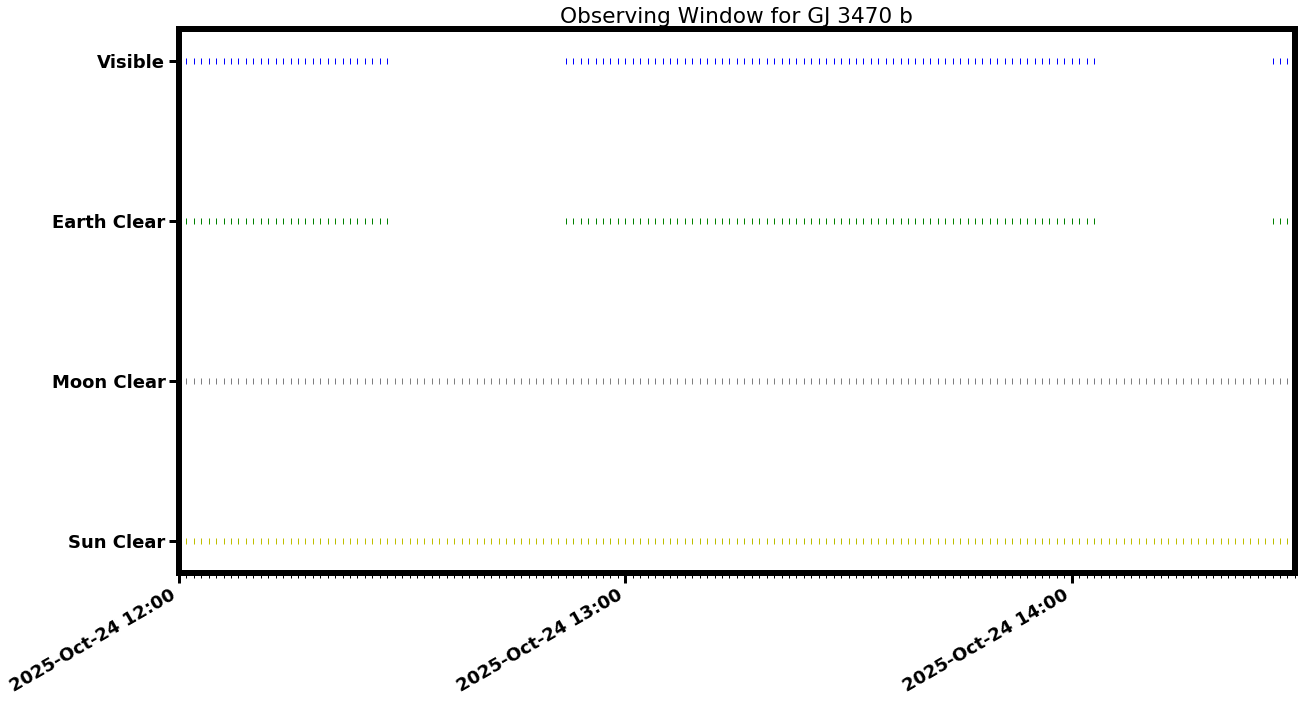

In [51]:
# Zoom in plot of just a few hours
fig, axs = plt.subplots(1,1, figsize=(20,10))
axs.plot(dt_iso_utc[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 
         Sun_r[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 'y|')
axs.plot(dt_iso_utc[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 
         Moon_r[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 'C7|')
axs.plot(dt_iso_utc[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 
         Earth_r[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 'g|')
axs.plot(dt_iso_utc[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 
         all_req[np.where((start<=dt_iso_utc) & (dt_iso_utc<=stop))], 'b|')

axs.set_title('Observing Window for %s' %planet_name)
axs.xaxis.set_major_locator(mpl.dates.HourLocator())
axs.xaxis.set_minor_locator(mpl.dates.MinuteLocator())
axs.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%b-%d %H:%M'))
axs.set_yticks([0,0.25, 0.5, 0.75, 1])
axs.set_yticklabels(['Blocked', 'Sun Clear', 'Moon Clear', 'Earth Clear', 'Visible'])
for label in axs.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
axs.set_ylim(0.2, 1.05)
axs.set_xlim(start, stop)
plt.show()

# Visual checks on coordinate shifts

### Plot Earth reference frame orbits of Pandora, Moon, & Sun

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ex, ey, ez, color='g')
ax.scatter3D(px, py, pz, color='r')
ax.set_title('Earth fixed Pandora orbit')

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ex, ey, ez, color='g')
ax.scatter3D(mx, my, mz, color='C7')
ax.set_title('Earth fixed Moon orbit')

In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ex, ey, ez, color='g')
ax.scatter3D(sx, sy, sz, color='y')
ax.set_title('Earth fixed Sun orbit')

### Plot Pandora reference frame orbits of Earth, Moon, & Sun

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ex[0], ey[0], ez[0], color='g', label='Earth')
ax.scatter3D(px[0], py[0], pz[0], color='r', label='Pandora')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(exx[i], eyy[i], ezz[i], color='g', label='Earth')
ax.scatter3D(pxx[i], pyy[i], pzz[i], color='r', label='Pandora')
plt.legend()
plt.show()


In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(ex, ey, ez, color='g')
ax.scatter3D(px, py, pz, color='r')
ax.scatter3D(mx, my, mz, color='gray')
plt.show()

fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(pxx, pyy, pzz, color='r')
ax.scatter3D(exx, eyy, ezz, color='g')
ax.scatter3D(mxx, myy, mzz, color='gray')


In [ ]:
fig = plt.figure(figsize=(25,25))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(pxx, pyy, pzz, color='r')
ax.scatter3D(sxx, syy, szz, color='y')

### 'Sky' projections from Pandora

In [ ]:
# Produce RA and Dec values for each body in Pandora reference frame at each time step
ss_ra  = ss.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
ss_dec = ss.icrs.transform_to('fk5').dec.radian

ee_ra  = ee.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
ee_dec = ee.icrs.transform_to('fk5').dec.radian

mm_ra  = mm.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
mm_dec = mm.icrs.transform_to('fk5').dec.radian

pp_ra  = pp.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
pp_dec = pp.icrs.transform_to('fk5').dec.radian

In [ ]:
plt.figure(figsize=(20,10)) 
plt.subplot(111, projection="aitoff")
plt.title("Projection of Earth, Moon, Sun from Pandora ref frame")
plt.grid(True)
plt.plot(ee_ra, ee_dec, 'o', markersize=2, color='g', label='Earth')
plt.plot(mm_ra, mm_dec, 'o', markersize=2, color='grey', label='Moon')
plt.plot(ss_ra, ss_dec, '*', markersize=2, color='y', label='Sun')
plt.plot(pp_ra, pp_dec, 'o', markersize=2, color='r', label='Pandora')
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.legend()
plt.show()

In [ ]:
ss0 = SkyCoord(x=sxx[0], y=syy[0], z=szz[0], unit='km', representation_type='cartesian')
pp0 = SkyCoord(x=pxx[0], y=pyy[0], z=pzz[0], unit='km', representation_type='cartesian')
ee0 = SkyCoord(x=exx[0], y=eyy[0], z=ezz[0], unit='km', representation_type='cartesian')
mm0 = SkyCoord(x=mxx[0], y=myy[0], z=mzz[0], unit='km', representation_type='cartesian')

In [ ]:
gj3470_ra  = planet.icrs.ra.wrap_at(180 * u.deg).radian
gj3470_dec = planet.icrs.dec.radian

ss0_ra  = ss0.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
ss0_dec = ss0.icrs.transform_to('fk5').dec.radian

pp0_ra  = pp0.icrs.transform_to('fk5').ra.wrap_at(180 * u.deg).radian
pp0_dec = pp0.icrs.transform_to('fk5').dec.radian

In [ ]:
plt.figure(figsize=(8,4.2)) 
plt.subplot(111, projection="aitoff")
plt.title("Projection of Sun and GJ3470 from Pandora ref frame")
plt.grid(True)
plt.plot(gj3470_ra, gj3470_dec, 'o', markersize=2, color='purple', label='GJ 3470')
plt.plot(ss0_ra, ss0_dec, 'o', markersize=2, color='y', label='Sun')
plt.plot(pp0_ra, pp0_dec, 'o', markersize=2, color='r', label='Pandora')
plt.legend()
plt.subplots_adjust(top=0.95,bottom=0.0)
plt.show()